In [41]:
# Install dependencies
!pip install openai pandas tqdm

# Step 1: Imports
import openai
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
from google.colab import userdata
# Step 2 Retrieve OpenAI API key from Colab secrets
Simon_GBA_479_Class = userdata.get('Simon_GBA_479_Class')


# Initialize the OpenAI client
client = openai.OpenAI(api_key=Simon_GBA_479_Class)

In [10]:
# Step 3: Load support notes
from google.colab import files
uploaded = files.upload()



Saving support_notes.csv to support_notes.csv


In [12]:
# Step 3: Load support notes
df = pd.read_csv('/content/support_notes.csv')
df = df.dropna(subset=['support_note'])  # Ensure no missing notes
df.head()

,note_id,support_note
0,1,Several users reported being unable to access ...
1,2,Dashboard views were noticeably slower than us...
2,3,Billing totals shown in reports did not align ...
3,4,Customers experienced intermittent API timeout...
4,5,Report generation failed repeatedly for month-...


In [20]:
def get_response_from_messages(messages_input, model_input = "gpt-5-nano"):
    response = client.responses.create(
        model = model_input,
        input = messages_input,
    )

    response = response.output_text

    return response

In [55]:
def extract_fields_from_note(note):
    prompt = f"""
You are a helpful assistant analyzing internal customer support notes. Extract the following fields from the note below:
- Issue_Type: e.g., access problem, bug, system outage, customer complaint, etc.
- Affected_System: Name of internal systems or tools mentioned
- Severity: High, Medium, Low
- Resolution_Status: Resolved, Unresolved, Escalated
- Follow_Up_Needed: Yes or No
- Time_to_Resolution: Time it took to resolve (in hours or days), if mentioned

Support Note:
{note}

Return your answer as JSON.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-5-nano",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content

    except Exception as e:
        print(f"Error: {e}")
        return None

In [22]:
import json

structured_data = []

for note in tqdm(df['support_note'], desc="Processing notes"):
    result = extract_fields_from_note(note)
    try:
        parsed = json.loads(result)
        structured_data.append(parsed)
    except:
        structured_data.append({
            "Issue_Type": None,
            "Affected_System": None,
            "Severity": None,
            "Resolution_Status": None,
            "Follow_Up_Needed": None,
            "Time_to_Resolution": None
        })
    time.sleep(1.1)  # Avoid rate limit

Processing notes: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it]


In [23]:
structured_df = pd.DataFrame(structured_data)
final_df = pd.concat([df, structured_df], axis=1)

# Save the cleaned structured data
final_df.to_csv("structured_support_data.csv", index=False)
print("Structured data saved to structured_support_data.csv")


Structured data saved to structured_support_data.csv


In [25]:
# Try a single note before running full loop
test_note = df['support_note'].iloc[0]
print(extract_fields_from_note(test_note))

{
"Issue_Type": "access problem",
"Affected_System": "Authentication service",
"Severity": "High",
"Resolution_Status": "Resolved",
"Follow_Up_Needed": "No",
"Time_to_Resolution": "Not mentioned"
}


In [31]:
print(final_df.head())

   note_id                                       support_note  \
0        1  Several users reported being unable to access ...   
1        2  Dashboard views were noticeably slower than us...   
2        3  Billing totals shown in reports did not align ...   
3        4  Customers experienced intermittent API timeout...   
4        5  Report generation failed repeatedly for month-...   

                  Issue_Type         Affected_System       Severity  \
0             access problem  Authentication service           High   
1          Performance issue               Dashboard         Medium   
2          Data sync problem   Billing and Reporting  Not Mentioned   
3  Intermittent API timeouts                     API  Not Mentioned   
4                        Bug       Reporting service           High   

  Resolution_Status Follow_Up_Needed Time_to_Resolution  
0          Resolved               No      Not mentioned  
1          Resolved               No      Not mentioned  
2       

In [33]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   note_id             40 non-null     int64 
 1   support_note        40 non-null     object
 2   Issue_Type          40 non-null     object
 3   Affected_System     40 non-null     object
 4   Severity            40 non-null     object
 5   Resolution_Status   40 non-null     object
 6   Follow_Up_Needed    40 non-null     object
 7   Time_to_Resolution  40 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.6+ KB


In [34]:
# Re-import libraries after code state reset
import pandas as pd

# Reload the uploaded file
from google.colab import files
uploaded = files.upload()



# Show first few rows
structured_df.head()


Saving structured_support_data.csv to structured_support_data (1).csv


,Issue_Type,Affected_System,Severity,Resolution_Status,Follow_Up_Needed,Time_to_Resolution
0,access problem,Authentication service,High,Resolved,No,Not mentioned
1,Performance issue,Dashboard,Medium,Resolved,No,Not mentioned
2,Data sync problem,Billing and Reporting,Not Mentioned,Resolved,No,Couple of hours
3,Intermittent API timeouts,API,Not Mentioned,Unresolved,Yes,Not Mentioned
4,Bug,Reporting service,High,Resolved,No,Same day


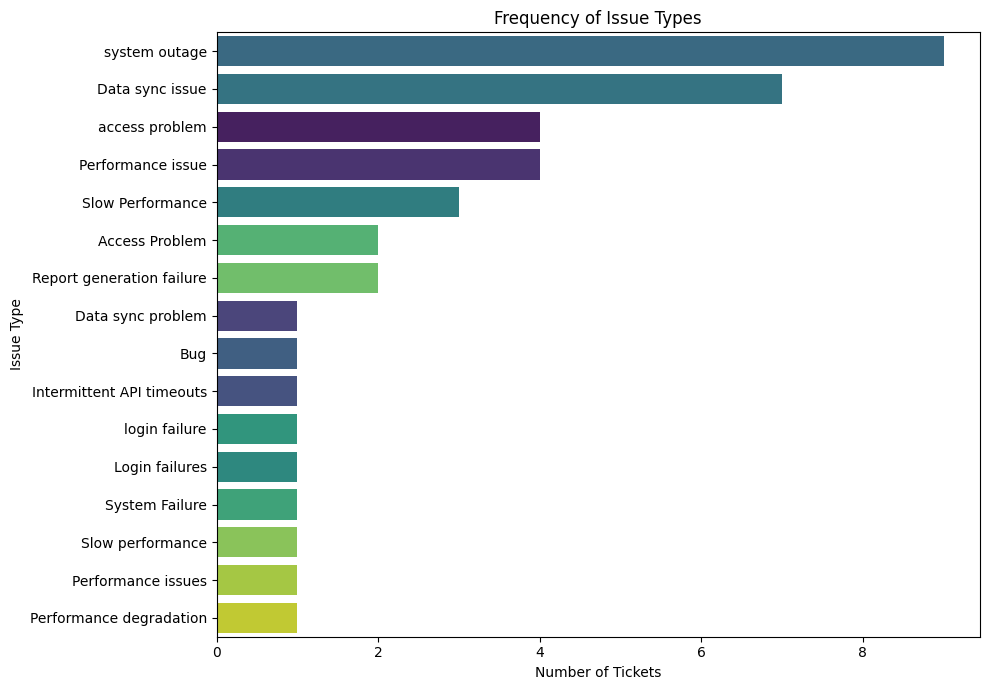

In [47]:
# Chart 1: Frequency of Issue Types
plt.figure(figsize=(10, 7))
sns.countplot(data=structured_df, y='Issue_Type', order=structured_df['Issue_Type'].value_counts().index,
              palette='viridis', hue='Issue_Type', legend=False)
plt.title('Frequency of Issue Types')
plt.xlabel('Number of Tickets')
plt.ylabel('Issue Type')
plt.tight_layout()
plt.savefig('/content/issue_type_frequency.png')
plt.show()

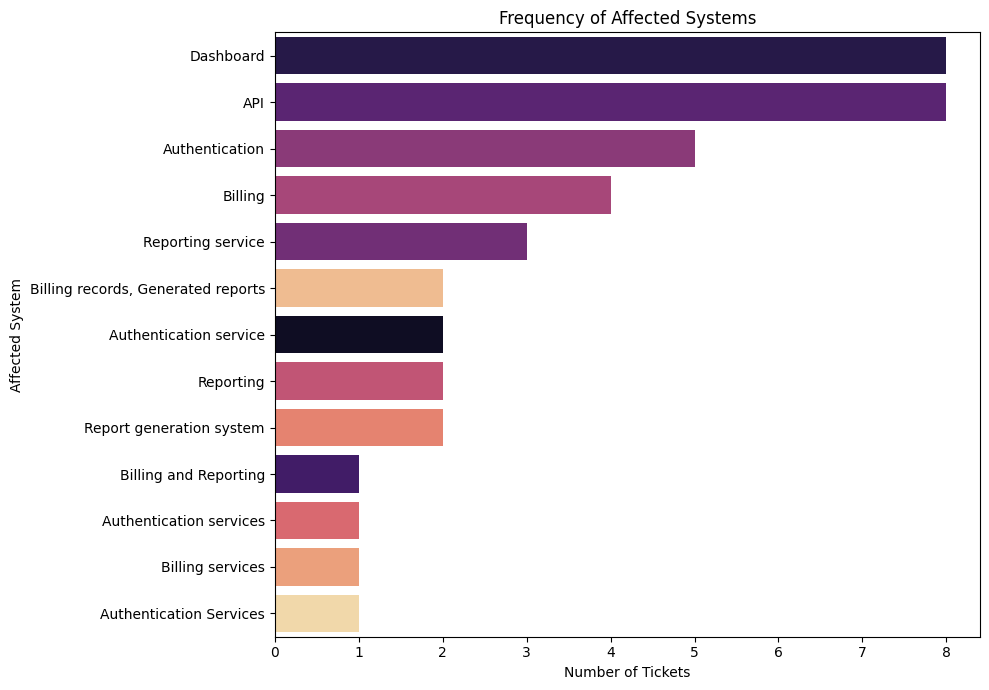

In [54]:
# Chart 2: Frequency of Affected System
plt.figure(figsize=(10, 7))
sns.countplot(data=structured_df, y='Affected_System', order=structured_df['Affected_System'].value_counts().index,
              palette='magma', hue='Affected_System', legend=False)
plt.title('Frequency of Affected Systems')
plt.xlabel('Number of Tickets')
plt.ylabel('Affected System')
plt.tight_layout()
plt.savefig('/content/affected_system_frequency.png')
plt.show()

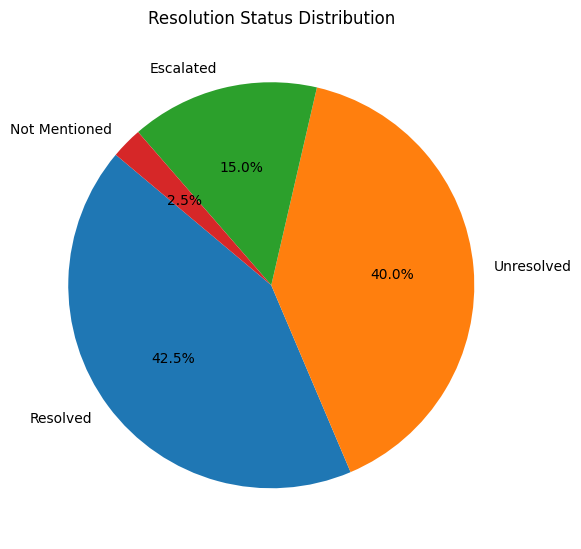

In [51]:
# Chart 3: Resolution Status Distribution
plt.figure(figsize=(6, 6))
structured_df['Resolution_Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Resolution Status Distribution")
plt.ylabel("")  # Hide y-label
plt.tight_layout()
plt.savefig("/content/resolution_status_pie.png")
plt.show()

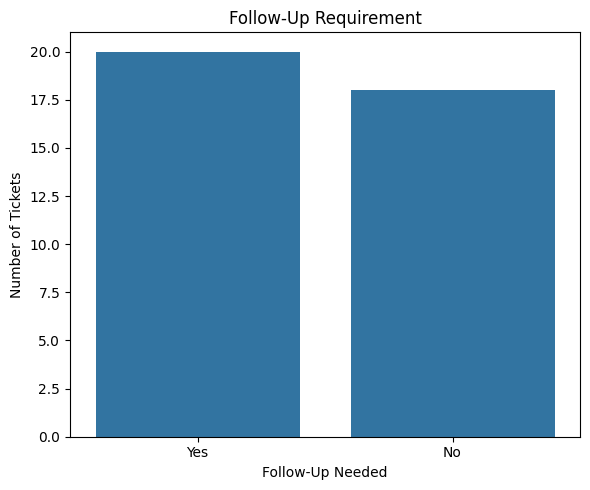

In [53]:
# Chart 4: Follow-Up Needed Count
plt.figure(figsize=(6, 5))
sns.countplot(data=structured_df, x='Follow_Up_Needed', order=['Yes', 'No'])
plt.title("Follow-Up Requirement")
plt.xlabel("Follow-Up Needed")
plt.ylabel("Number of Tickets")
plt.tight_layout()
plt.savefig("/content/follow_up_needed_bar.png")
plt.show()